

https://www.kaggle.com/christofhenkel/keras-baseline

In [1]:
# Install the plaidml backend
## DO THIS BEFORE IMPORTING KERAS OR TENSOR TO USE PLAIDML
import plaidml.keras
plaidml.keras.install_backend()

# Help MacOS be able to use Keras
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
# Gets rid of the processor warning.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Concatenate, Conv2DTranspose, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# from tqdm.keras import TqdmCallback
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import glob
import cv2
import os

import skimage.io

%matplotlib inline

# Settings

In [4]:
# GLOBAL PARAMS #

TRAIN_IMAGE_DIR = '../images/network_training/build/0/'
TRAIN_MASK_DIR = '../images/network_training/mask/0/'
TEST_IMAGE_DIR = '../images/network_training/test/0/'
DATA_DIR = '../data/'


# images to split and feed into the generator
# decrease this number if running out of GPU memory
# works with 4 on 11GB GPU
images_per_batch = 4

# val split from training set
train_val_split_size = .1


# IMAGE SPLITTER PARAMS #

split_rows = 20
split_cols = 20
img_resize_width = 4800
img_resize_height = 4800


# MODEL PARAMS #

epochs = 1
batch_size = 8
pretrained_model = False
model_name = 'testing_model'
model_path = os.path.join(DATA_DIR, model_name + '.h5')
plot_epoch_val_images = True
early_stop = EarlyStopping(patience=5, verbose=1)
check_point = ModelCheckpoint(os.path.join(DATA_DIR, model_name + '.hdf5'),
                              save_best_only=True,
                              verbose=1)

In [5]:
train_dir_images = glob.glob(TRAIN_IMAGE_DIR + '*')
train_filenames = [os.path.basename(x) for x in train_dir_images]

test_dir_images = glob.glob(TEST_IMAGE_DIR + '*')
test_filenames = [os.path.basename(x) for x in test_dir_images]

# create batch sets of 'images_per_batch' size
training_sets = [train_filenames[i :i + images_per_batch] for i in range(0,len(train_filenames),images_per_batch)][:1]

### Functions

In [6]:
class ValPlotCallback(Callback):

    def on_train_end(self, logs=None):
        print('VALIDATION IMAGES')
        X_val_pred = model.predict(X_val, verbose=1, batch_size=batch_size)
        X_val_pred_mask = (X_val_pred > 0.5).astype(np.uint8)
        plot_predictions(original=X_val,
                         predicted=X_val_pred,
                         predicted_mask=X_val_pred_mask,
                         ground_truth=y_val,
                         repeat=True)

In [7]:
def shape_and_mem(array):
    print(f'Shape: {array.shape}')
    print(f'Size: {round(array.itemsize * array.size / 1024 / 1024 / 1024, 3)} GB')

In [22]:
def image_splitter(image, num_col_splits, num_row_splits, resize=False, resize_width=None, resize_height=None):
    """
    Splits an image into 'num_col_splits' X 'num_row_splits'
    Resize by setting resize=True and specifying 'resize_width' and 'resize_height'
    Returns array of images arranged from left -> right, top -> bottom
    """
    if resize:
        image = cv2.resize(image, (resize_width, resize_height))
    
    width = image.shape[0] 
    height = image.shape[1]
    imglist = []

    for startpoint in np.linspace(0,width,num_col_splits, endpoint=False):
        endpoint=startpoint + (width / num_col_splits)

        for startp2 in np.linspace(0,height,num_row_splits, endpoint=False):
            endp2=startp2 + (height / num_row_splits)

            imglist.append(image[int(startp2):int(endp2), int(startpoint):int(endpoint)]
                        )
    return np.array(imglist)

In [9]:
def image_checker(original, ground_truth):
    
    for _ in range(4):
        ix = np.random.randint(0, original.shape[0])
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 24))

        ax1.set_title('Original')
        ax1.imshow(original[ix])
        ax1.axis('off')

        ax2.set_title('Ground Truth')
        ax2.imshow(np.squeeze(ground_truth[ix]))
        ax2.axis('off')    

        plt.subplots_adjust(wspace=.3, hspace=.3)
        plt.show()

In [10]:
def make_model(pretrained_model=False, model_name=model_name):
    '''
    Creates a new U-Net model
    '''
    if pretrained_model or batch_number > 1:
        print('Loading Trained Model')
        model = load_model(model_path)
        print()
    else:
        print('Creating New Model')
        print()
        inputs = Input((X_train.shape[1], X_train.shape[2], 3))
        s = Lambda(lambda x: x) (inputs) # removed / 255

        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # model.summary()
        
    return model

In [11]:
def plot_predictions(original, predicted, predicted_mask, ground_truth=None, repeat=False):

    ncols_calc = 3
    if ground_truth is not None:
        ncols_calc = 4
        
    
    for i in range(4):
        if repeat:
            ix = i
        else:
            ix = np.random.randint(0, predicted.shape[0])
            
        fig, ax = plt.subplots(ncols=ncols_calc, figsize=(ncols_calc*5, 24))

        ax[0].set_title('Original')
        ax[0].imshow(original[ix])
        ax[0].axis('off')

        ax[1].set_title('Predicted')
        ax[1].imshow(np.squeeze(predicted[ix]))
        ax[1].axis('off')    

        ax[2].set_title('Predicted Mask')
        ax[2].imshow(np.squeeze(predicted_mask[ix]))
        ax[2].axis('off')
        
        if ground_truth is not None:
            ax[3].set_title('Ground Truth')
            ax[3].imshow(np.squeeze(ground_truth[ix]))
            ax[3].axis('off')

        plt.subplots_adjust(wspace=.3, hspace=.3)
        plt.show()

# Batch Process Images and Train on Batch


  0%|          | 0/4 [00:00<?, ?it/s]


********************
Batch Number 1 of 1
********************

Loading Images:




100%|██████████| 4/4 [00:17<00:00,  4.33s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


Shape: (1600, 240, 240, 3)
Size: 1.03 GB

Loading Masks:




100%|██████████| 4/4 [00:04<00:00,  1.12s/it]



Shape: (1600, 240, 240, 1)
Size: 0.343 GB


Checking images


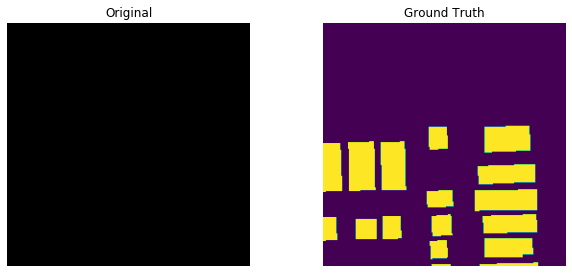

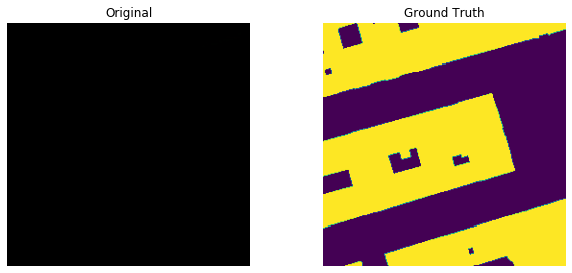

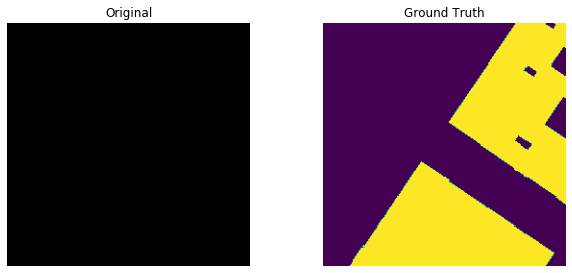

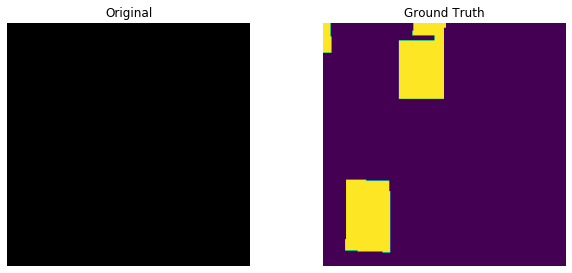

In [18]:
for batch_number, current_train_set in enumerate(training_sets, start=1):
    
    print()
    print('********************')
    print(f'Batch Number {batch_number} of {len(training_sets)}')
    print('********************')
    print()
    print('Loading Images:')
    print()

    # Load each image in current_train set in as uint8
    # Split image using image splitter
    # VStack the arrays together and normalize using /255
    X = [np.array(
            image_splitter(
                cv2.imread(TRAIN_IMAGE_DIR + process_img).astype(np.uint8), 
                num_col_splits=split_cols, 
                num_row_splits=split_rows,
                resize=True,
                resize_height=img_resize_height,
                resize_width=img_resize_width
            )
        ) for process_img in tqdm(current_train_set)]

    X = (np.vstack(X)/255).astype(np.float32)

    print()
    shape_and_mem(X)
    
    print()
    print('Loading Masks:')
    print()

    y = [np.array(
            image_splitter(  # 0 for grayscale
                cv2.imread(TRAIN_MASK_DIR + process_img, 0).astype(np.uint8),
                num_col_splits=split_cols,
                num_row_splits=split_rows,
                resize=True,
                resize_height=img_resize_height,
                resize_width=img_resize_width
            )
        ) for process_img in tqdm(current_train_set)]

    y = (np.vstack(y)/255).astype(np.float32)
    
    # Expand dims because it's grayscale
    y = np.expand_dims(y, axis=3)
    
    print()
    shape_and_mem(y)
    print()

    #Test if images look okay

    print()
    print('Checking images')
    image_checker(original=X, ground_truth=y)

  0%|          | 0/4 [00:00<?, ?it/s]


********************
Batch Number 1 of 1
********************

Loading Images:



  0%|          | 0/4 [00:00<?, ?it/s]


Shape: (1600, 240, 240, 3)
Size: 1.03 GB

Loading Masks:



 75%|███████▌  | 3/4 [00:03<00:01,  1.17s/it]/Users/chris/opt/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 4/4 [00:04<00:00,  1.19s/it]



Shape: (1600, 240, 240, 1)
Size: 0.343 GB

Train / Val Splitting

X_train
Shape: (1440, 240, 240, 3)
Size: 0.927 GB

y_train
Shape: (1440, 240, 240, 1)
Size: 0.309 GB
Creating New Model


Fitting Model

Train on 1440 samples, validate on 160 samples
1432/1440 [============================>.] - ETA: 1s - loss: 0.0375 - accuracy: 0.6613
Epoch 00001: val_loss improved from inf to 0.00898, saving model to ../data/testing_model.hdf5
1440/1440 [==============================] - 222s 154ms/sample - loss: 0.0373 - accuracy: 0.6610 - val_loss: 0.0090 - val_accuracy: 0.6719
VALIDATION IMAGES
160/160 [==============================] - 6s 34ms/sample


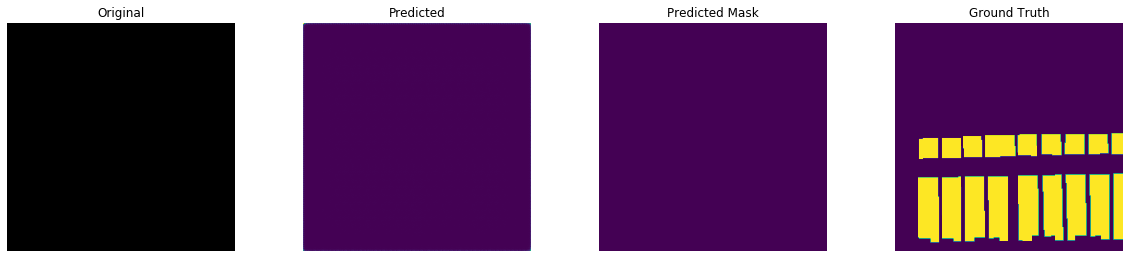

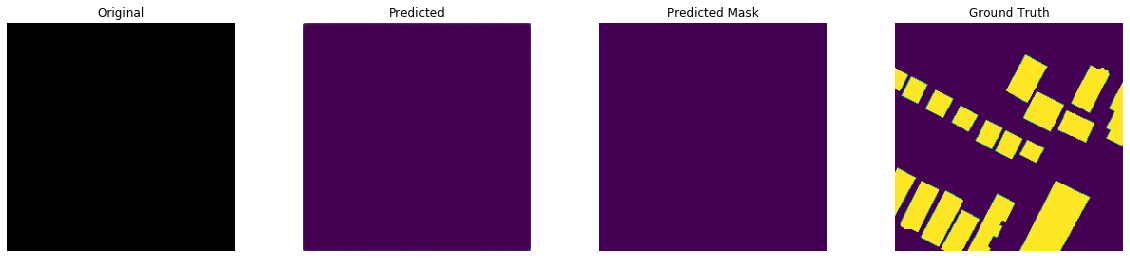

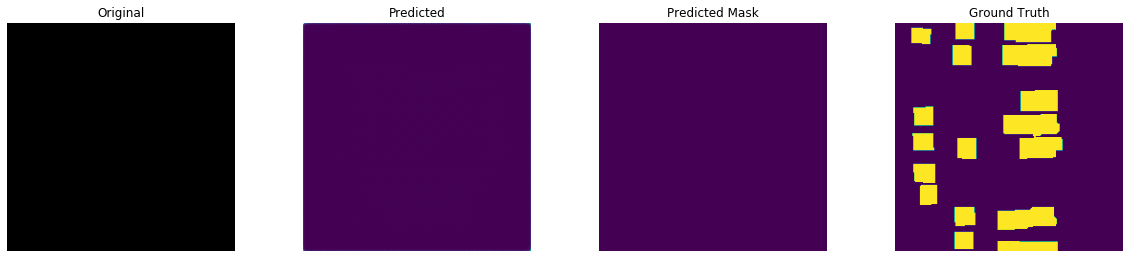

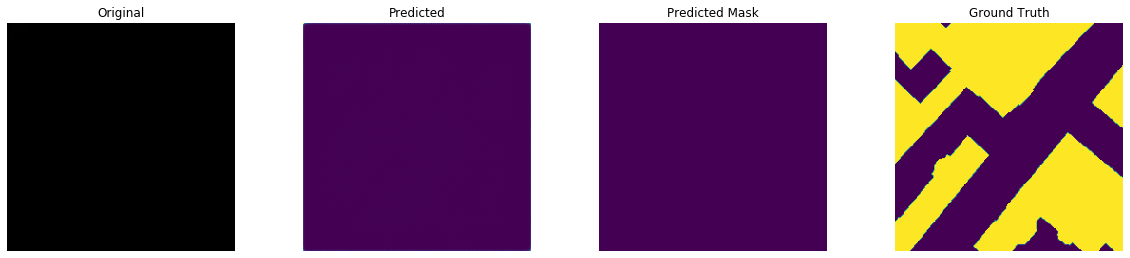

***###!!! DONE !!!###***


In [12]:
    print('Train / Val Splitting')
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=23, test_size =train_val_split_size)
    print()
    print('X_train')
    shape_and_mem(X_train)
    print()
    print('y_train')
    shape_and_mem(y_train)

    model = make_model(pretrained_model=pretrained_model, model_name=model_name)

    print()
    print('Fitting Model')
    print()

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)

    # datagen = ImageDataGenerator(
    #                             featurewise_center=False,
    #                             featurewise_std_normalization=False
    #                             )

    # NOT using this at the moment ########################################################
    # datagen.fit(X_train)

    # Use datagen to split data into smaller batches for training.

    # history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
    #                     epochs=epochs, 
    #                     validation_data=(X_val, y_val),
    #                     verbose=1, 
    #                     steps_per_epoch=X_train.shape[0] // batch_size,
    #                     validation_steps=(X_train.shape[0] // batch_size) * train_val_split_size,
    #                     callbacks=[early_stop, check_point])

    #####################################################################################

    model.fit(X_train, y_train, 
                batch_size=batch_size,
                epochs=epochs, 
                validation_data=(X_val, y_val),
                verbose=1, 
                steps_per_epoch=X_train.shape[0] // batch_size,
                validation_steps=(X_train.shape[0] // batch_size) * train_val_split_size,
                callbacks=[early_stop, check_point, ValPlotCallback()])
    
    # save model and architecture to single file
    model.save(model_path)
    print('***###!!! DONE !!!###***')

# Model Performance

In [14]:
# model = load_model(model_path)

## Validation

In [ ]:
X_val_pred = model.predict(X_val, verbose=1, batch_size=batch_size)

model.evaluate(x=X_val, y=y_val, batch_size=batch_size)

# simple threshold to change to 1/0, mask
X_val_pred_mask = (X_val_pred > 0.5).astype(np.uint8)

plot_predictions(original=X_val, predicted=X_val_pred, predicted_mask=X_val_pred_mask, ground_truth=y_val)

## Testing

https://www.jeremyjordan.me/evaluating-image-segmentation-models/

In [ ]:
X_test = [np.array(
        image_splitter(
            cv2.imread(TEST_IMAGE_DIR + img_name).astype(np.uint8), 
            num_col_splits=split_cols, 
            num_row_splits=split_rows,
            resize=True,
            resize_height=img_resize_height,
            resize_width=img_resize_width
        )
    ) for img_name in tqdm(test_filenames[:10])]

X_test = (np.vstack(X_test)/255).astype(np.float32)

In [ ]:
shape_and_mem(X_test)

In [ ]:
X_test[2]

In [ ]:
def image_tester(original):
    
    for _ in range(4):
        ix = np.random.randint(0, original.shape[0])
        fig, ax = plt.subplots(figsize=(10, 24))

        ax.set_title('Original')
        ax.imshow(original[ix])
        ax.axis('off')

        plt.show()

In [ ]:
image_tester(X_test)

In [ ]:
X_test_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

In [ ]:
shape_and_mem(y_pred)

In [ ]:
X_test_pred_mask = (y_pred > 0.5).astype(np.uint8)

In [ ]:
plot_predictions(original=X_test, predicted=X_test_pred, predicted_mask=X_test_pred_mask)

In [ ]:
result = cv2.bitwise_and(test_split[0], test_split[0], mask=prediction[0])

In [ ]:
result